In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import json

import sim_steady_state_fast as sim

In [2]:
# for plotting: uncomment second line to get plots with exact style
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (6, 3)})
plt.rcParams.update({'text.usetex': True, 'font.serif': 'Palatino'})

## Core calibration and example steady state

In [3]:
rho_e = 0.91**(1/4)     # annual rho=0.91 from IKC
sd_e = 0.92             # cross-sectional sd from IKC
n_e = 11                # 11 points for Rouwenhorst approximation

e, pi_e, Pi_e = sim.discretize_income(rho_e, sd_e, n_e)

min_a = 0               # borrowing constraint of 0 (no borrowing)
max_a = 4000
n_a = 400
a_grid = sim.discretize_assets(min_a, max_a, n_a)

r = 0.02/4              # annual r=2% from ARE
beta = 0.985            # arbitrary discount factor prior to exact calibration
eis = 1                 # elasticity of intertemporal substitution = 1 (log utility)

calib = dict(a_grid=a_grid, y=e, Pi=Pi_e, r=r, beta=beta, eis=eis)
ss = sim.steady_state(**calib)
ss['A'] / 4 # report annualized assets over income

2.760508428637379

## Examples: visualizing consumption policy functions
Look at the lower endowment states so that the concavity is more visible.

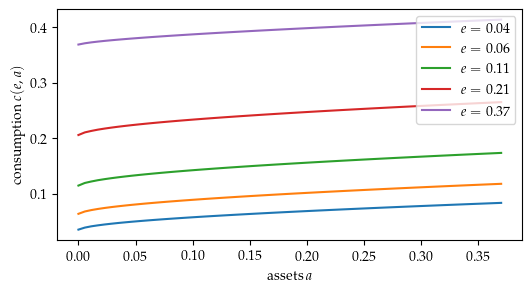

In [4]:
for ei, ee in enumerate(e[:5]):
    plt.plot(a_grid[:50], ss['c'][ei, :50], label=rf'$e={ee:.2f}$')
plt.legend()
plt.xlabel(r'assets $a$')
plt.ylabel(r'consumption $c(e,a)$')
plt.savefig("figures/lecture1_fig1.pdf", transparent=True, bbox_inches='tight')

### Visualizing associated savings functions...

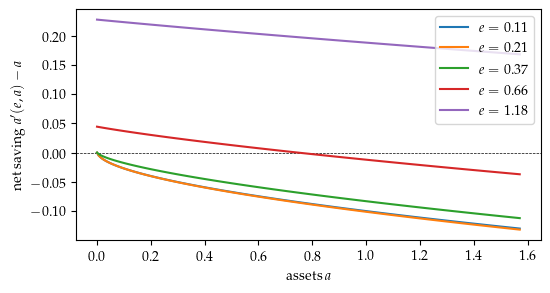

In [5]:
ia = 120
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
for ei, ee in enumerate(e):
    if 2 <= ei <= 6:
        plt.plot(a_grid[:ia], ss['a'][ei, :ia] - a_grid[:ia], label=rf'$e={ee:.2f}$')
plt.legend()
plt.xlabel(r'assets $a$')
plt.ylabel(r"net saving $a'(e,a)-a$")
plt.savefig("figures/lecture1_fig2.pdf", transparent=True, bbox_inches='tight')

### Visualizing distributions

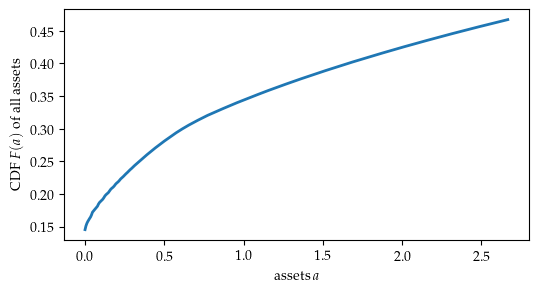

In [6]:
Fa = ss['D'].sum(axis=0).cumsum()
plt.plot(a_grid[:150], Fa[:150], linewidth=2)
plt.xlabel(r'assets $a$')
plt.ylabel(r"CDF $F(a)$ of all assets")
plt.savefig("figures/lecture1_fig3.pdf", transparent=True, bbox_inches='tight')

# Asset - MPC tradeoff
First write rough code that numerically calculates MPCs at each point from the policy function:

In [7]:
def get_mpcs(ss):    
    c, a, a_grid, r = ss['c'], ss['a'], ss['a_grid'], ss['r']
    mpcs = np.empty_like(c)
        
    # symmetric differences away from boundaries
    mpcs[:, 1:-1] = (c[:, 2:] - c[:, 0:-2]) / (a_grid[2:] - a_grid[:-2]) / (1+r)

    # asymmetric first differences at boundaries
    mpcs[:, 0]  = (c[:, 1] - c[:, 0]) / (a_grid[1] - a_grid[0]) / (1+r)
    mpcs[:, -1] = (c[:, -1] - c[:, -2]) / (a_grid[-1] - a_grid[-2]) / (1+r)

    # special case of constrained, enforce MPC = 1
    mpcs[a == a_grid[0]] = 1
    return mpcs

Now setting $Z=0.7$, calibrating different $\beta$:

In [8]:
calib['y'] = 0.7*e
betas = [0.9, 0.92, 0.94, 0.95, 0.96, 0.97, 0.98, *np.linspace(0.982, 0.992, 10)]

As, MPCs_inc, MPCs_unw = [], [], []
for beta in betas:
    ss = sim.steady_state(**{**calib, 'beta': beta})
    As.append(ss['A'])
    MPCs_inc.append((ss['D'] * get_mpcs(ss) * e[:, np.newaxis]).sum()) # income-weighted average
    MPCs_unw.append((ss['D'] * get_mpcs(ss)).sum())                    # unweighted average
As = np.array(As) / 4 # annualize assets

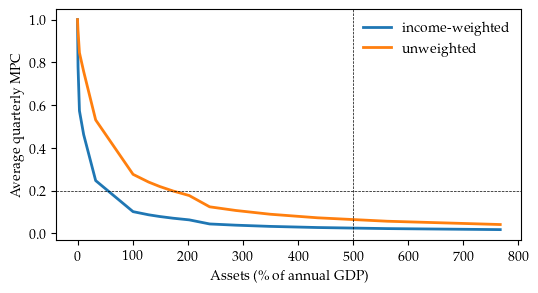

In [9]:
plt.plot(100*As, MPCs_inc, linewidth=2, label='income-weighted')
plt.plot(100*As, MPCs_unw, linewidth=2, label='unweighted')
plt.legend(frameon=False)
plt.axhline(0.2, color='k', linestyle='--', linewidth=0.5)
plt.axvline(500, color='k', linestyle='--', linewidth=0.5)

plt.xlabel(r'Assets (\% of annual GDP)')
plt.ylabel(r"Average quarterly MPC")

plt.savefig("figures/lecture1_fig4.pdf", transparent=True, bbox_inches='tight')

# Calibration with $\beta$ heterogeneity

Transition matrix for $\beta$:

In [10]:
omega = 0.5     # 50-50 split of beta types (from near 50-50 split in ARE)
q = 0.01        # draw new beta every 25 years
pi_b = np.array([1 - omega, omega])
Pi_b = (1-q)*np.eye(2) + q*np.outer(np.ones(2), pi_b)

Get transition matrix for combined state, plus augmented $e$ vector:

In [11]:
Pi = np.kron(Pi_b, Pi_e)
e = np.kron(np.ones(2), e)
calib.update({'Pi': Pi, 'y': 0.7*e})

Function mapping vector `x` with the two $\beta$ into a `beta` that enters into our steady-state function:

In [12]:
def construct_beta(x):
    beta = np.kron(x, np.ones(n_e)) # 
    return beta[:, np.newaxis]      # need it to be column vector for backward_iteration() to work unchanged

Hit both calibration targets:

In [13]:
A_target = 5 * 4
mpc_target = 0.2
def evaluate_calibration(x):
    print(x)
    try:
        ss = sim.steady_state(**{**calib, 'beta': construct_beta(x)})
    except ValueError:
        # if steady state raises an error, likely because implied assets infinite
        return 10000, 0
    mpc_weighted = (ss['D'] * get_mpcs(ss) * e[:, np.newaxis]).sum()
    return ss['A'] - A_target, mpc_weighted - mpc_target

In [14]:
res = optimize.root(evaluate_calibration, np.array([0.95, 1.0]), tol=1E-9)

[0.95 1.  ]
[0.95 1.  ]
[0.95 1.  ]
[0.95000001 1.        ]
[0.95       1.00000001]
[0.95347569 0.99884422]
[0.95404277 0.99835242]
[0.95449415 0.99799183]
[0.95494939 0.99787025]
[0.95480684 0.99788414]
[0.95482084 0.99788005]
[0.95482442 0.99787893]
[0.95482669 0.99787822]
[0.95482669 0.99787821]
[0.95482669 0.99787821]


In [15]:
beta_lo, beta_hi = res.x
beta_lo, beta_hi

(0.9548266877101642, 0.9978782145690668)

In [16]:
beta_gap = beta_hi - beta_lo
beta_gap

0.04305152685890257

# New tradeoff with heterogeneity

In [17]:
betas_hi = [0.9, 0.92, 0.94, 0.95, 0.96, 0.97, 0.98, *np.linspace(0.982, 1.0, 20)]
As_het, MPCs_inc_het = [], []
for beta_hi_cur in betas_hi:
    ss = sim.steady_state(**{**calib, 'beta': construct_beta(np.array([beta_hi_cur - beta_gap, beta_hi_cur]))})
    As_het.append(ss['A'])
    MPCs_inc_het.append((ss['D'] * get_mpcs(ss) * e[:, np.newaxis]).sum()) # income-weighted average
As_het = np.array(As_het) / 4 # annualize assets

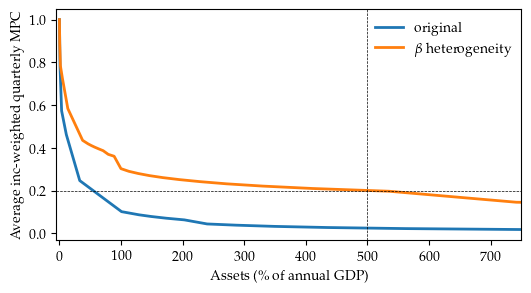

In [18]:
plt.plot(100*As, MPCs_inc, linewidth=2, label='original')
plt.plot(100*As_het, MPCs_inc_het, linewidth=2, label=r'$\beta$ heterogeneity')
plt.legend(frameon=False)
plt.xlim(-5, 750)
plt.axhline(0.2, color='k', linestyle='--', linewidth=0.5)
plt.axvline(500, color='k', linestyle='--', linewidth=0.5)

plt.xlabel(r'Assets (\% of annual GDP)')
plt.ylabel(r"Average inc-weighted quarterly MPC")

plt.savefig("figures/lecture1_fig5.pdf", transparent=True, bbox_inches='tight')

# Lorenz curve vs. US data

In [19]:
# load Lorenz curve in the 2019 SCF, interpolate to percentiles
lorenz_scf = np.loadtxt('inputs/lorenz_nw_scf_2019.raw', delimiter=',')

# get Lorenz curve implied by a given model steady state
def get_lorenz(ss, percentiles):
    D = ss['D'].sum(axis=0) # distribution over asset grid alone
    a_grid = ss['a_grid']
    lorenz_model = np.array([np.interp(pctl, D.cumsum(), (a_grid * D).cumsum()) / ss['A'] for pctl in percentiles])
    return lorenz_model

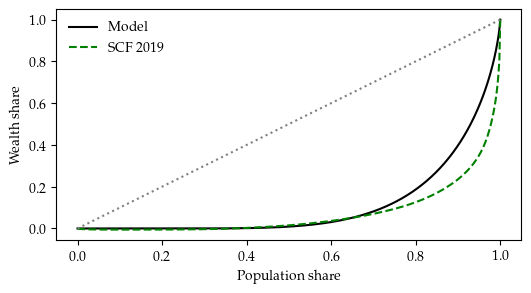

In [20]:
percentiles_detail = np.arange(501) / 500
lorenz_scf_detail = np.array([np.interp(pctl, lorenz_scf[:, 0], lorenz_scf[:, 1]) for pctl in percentiles_detail])
lorenz_model_detail = get_lorenz(ss, percentiles_detail)

plt.plot(percentiles_detail, lorenz_model_detail, label='Model', color='black')
plt.plot(percentiles_detail, lorenz_scf_detail, label='SCF 2019', linestyle='dashed', color='green')
plt.plot([0, 1], [0, 1], linestyle='dotted', color='gray')
plt.ylabel('Wealth share')
plt.xlabel('Population share')
plt.legend(frameon=False)
plt.savefig("figures/lecture1_fig6.pdf", transparent=True, bbox_inches='tight')

# Dynamics: shocks to $Z_s$ in our model

In [21]:
calib['beta'] = construct_beta(np.array([beta_lo, beta_hi]))
ss = sim.steady_state(**calib)

Function calculating transition in response to paths of $r_t^p$ and $Z_t$:

In [27]:
def calculate_transition(rps, Zs):
    T = len(rps)
    
    # backward iteration to get policies
    Va = ss['Va']
    a, c = np.empty((T, *ss['a'].shape)), np.empty((T, *ss['c'].shape))
    for t in reversed(range(T)):
        Va, a[t], c[t] = sim.backward_iteration(**{**calib, 'Va': Va, 'y': e*Zs[t], 'r': rps[t]})

    # forward iteration to get distributions and aggregates
    D = ss['D']
    A, C = np.empty(T), np.empty(T)
    for t in range(T):
        A[t], C[t] = np.vdot(a[t], D), np.vdot(c[t], D)
        a_i, a_pi = sim.interpolate_lottery_loop(a[t], a_grid)
        D = sim.forward_iteration(D, Pi, a_i, a_pi)

    return A, C

Shocks to $Z_t$ at different dates:

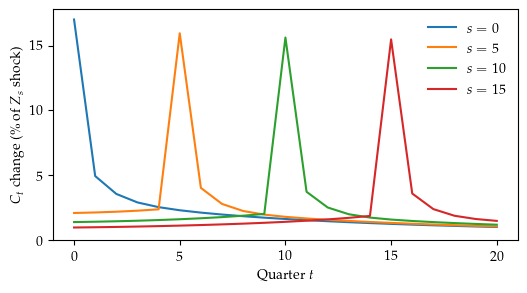

In [ ]:
for s in (0, 5, 10, 15):
    Zs = 0.7*(1 + 0.01*(np.arange(21)==s))
    rps = np.ones_like(Zs) * r
    A, C = calculate_transition(rps, Zs)
    plt.plot(100*(C-ss['C']) / 0.01 / 0.7, label=fr'$s={s}$')
plt.xlabel(r'Quarter $t$')
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 5, 10, 15])
plt.ylabel(r'$C_t$ change (\% of $Z_s$ shock)')
plt.legend(frameon=False)
plt.savefig("figures/lecture1_fig7.pdf", transparent=True, bbox_inches='tight')

Same for shocks to $r_t^p$ at different dates:

Implied MPC out of capital loss: -0.011


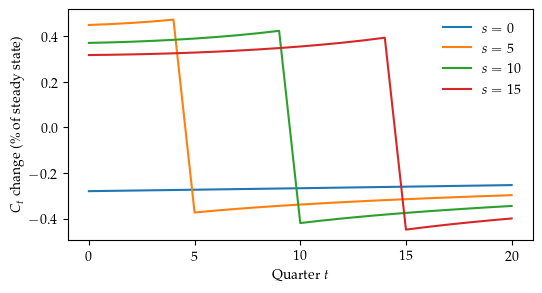

In [47]:
for s in (0, 5, 10, 15):
    Zs = np.ones_like(Zs) * 0.7
    rps = np.ones_like(Zs) * r - 0.01*(np.arange(21)==s)
    A, C = calculate_transition(rps, Zs)
    plt.plot(100*(C-ss['C']) / ss['C'], label=fr'$s={s}$')
    if s == 0:
        print(f"Implied MPC out of capital loss: {(C[0]-ss['C'])/(0.01*ss['A']):.3f}")
plt.xlabel(r'Quarter $t$')
plt.xticks([0, 5, 10, 15, 20])
plt.ylabel(r'$C_t$ change (\% of steady state)')
plt.legend(frameon=False)
plt.savefig("figures/lecture1_fig8.pdf", transparent=True, bbox_inches='tight')